### Importing Libraries

In [1]:
import os
import cv2
import random
import zipfile
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Multiply, Conv2D, Add, Activation, Reshape, Permute, Lambda
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_ref = zipfile.ZipFile('/content/drive/My Drive/GC10.zip', 'r')
zip_ref.extractall('/content/GC10')
zip_ref.close()

### Reading Data

In [5]:
df = pd.read_csv('/content/drive/My Drive/GC10_data.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    2306 non-null   int64 
 1   image_path    2306 non-null   object
 2   label         2306 non-null   int64 
 3   mapped_label  2306 non-null   object
 4   Filename      2306 non-null   object
 5   xml_filename  2306 non-null   object
dtypes: int64(2), object(4)
memory usage: 108.2+ KB


In [7]:
df.head()

,Unnamed: 0,image_path,label,mapped_label,Filename,xml_filename
0,0,/content/GC10/6/img_03_436152900_00535.jpg,6,silk_spot,img_03_436152900_00535.jpg,img_03_436152900_00535.xml
1,1,/content/GC10/6/img_06_4406645900_00501.jpg,6,silk_spot,img_06_4406645900_00501.jpg,img_06_4406645900_00501.xml
2,2,/content/GC10/6/img_02_4406645900_00346.jpg,6,silk_spot,img_02_4406645900_00346.jpg,img_02_4406645900_00346.xml
3,3,/content/GC10/6/img_06_4406645900_00490.jpg,6,silk_spot,img_06_4406645900_00490.jpg,img_06_4406645900_00490.xml
4,4,/content/GC10/6/img_01_425005700_00301.jpg,6,silk_spot,img_01_425005700_00301.jpg,img_01_425005700_00301.xml


### See if same data exists in two classes and remove them

In [8]:
#filter the rows with Filename where count is greater than 1

filename_counts = df.groupby('Filename')['Filename'].count()
filtered_filenames = filename_counts[filename_counts > 1].index.tolist()
filtered_df = df[df['Filename'].isin(filtered_filenames)]
len(filtered_df)

24

In [9]:
filtered_df['mapped_label'].value_counts()

,count
mapped_label,
welding_line,6
punching_hole,4
inclusion,4
rolled_pit,3
crescent_gap,2
waist_folding,2
silk_spot,1
water_spot,1
crease,1


In [10]:
#Remove the filtered df rows from original df

df = df[~df['Filename'].isin(filtered_filenames)]
len(df)

2282

### Data Distribution after Cleaning up

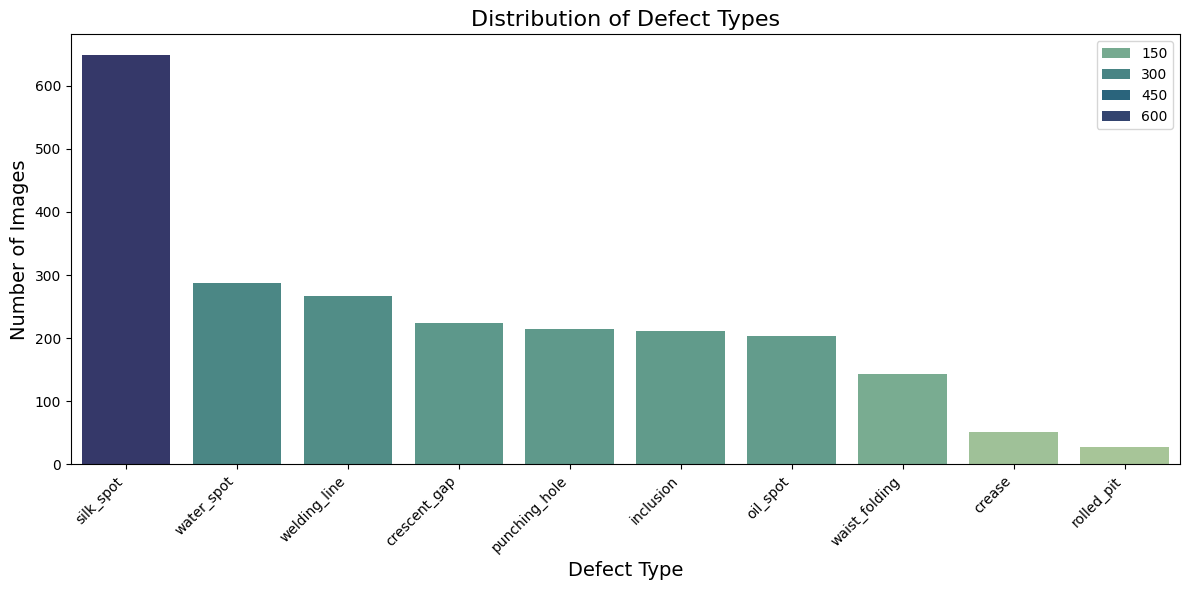

In [ ]:
label_counts = df['mapped_label'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, hue = label_counts.values,  palette='crest')
plt.title('Distribution of Defect Types', fontsize=16)
plt.xlabel('Defect Type', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#take the images from image_path column and see the size of all images and assign width and height to two seperate columns

def get_image_size(image_path):
  try:
    img = cv2.imread(image_path)
    if img is not None:
      height, width = img.shape[:2]
      return width, height
    else:
      return None, None
  except Exception as e:
    print(f"Error processing {image_path}: {e}")
    return None, None


df['width'], df['height'] = zip(*df['image_path'].apply(get_image_size))

In [ ]:
df.describe()

,Unnamed: 0,label,width,height
count,2282.000000,2282.000000,2282.0,2282.0
mean,1154.289220,4.861525,2048.0,1000.0
std,669.524778,2.400884,0.0,0.0
min,0.000000,1.000000,2048.0,1000.0
25%,572.250000,3.000000,2048.0,1000.0
50%,1150.500000,5.000000,2048.0,1000.0
75%,1737.500000,6.000000,2048.0,1000.0
max,2311.000000,10.000000,2048.0,1000.0


### Splitting the dataset into training and testing set

In [11]:
# split the df into training and test set
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['mapped_label'])

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 1825
Test set size: 457


In [12]:
train_df['mapped_label'].unique()

array(['inclusion', 'crescent_gap', 'rolled_pit', 'welding_line',
       'water_spot', 'oil_spot', 'silk_spot', 'punching_hole',
       'waist_folding', 'crease'], dtype=object)

In [13]:
test_df['mapped_label'].unique()

array(['welding_line', 'waist_folding', 'inclusion', 'water_spot',
       'silk_spot', 'punching_hole', 'crescent_gap', 'oil_spot', 'crease',
       'rolled_pit'], dtype=object)

In [14]:
# Define image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create a data generator for training and validation data
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='mapped_label',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='mapped_label',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1825 validated image filenames belonging to 10 classes.
Found 457 validated image filenames belonging to 10 classes.


### CNN + Ensemble Learning

In [ ]:
def build_cnn(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # Define a simple CNN architecture
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    model = Model(inputs=inputs, outputs=x)  # This model outputs feature vectors
    return model

In [ ]:
cnn_model = build_cnn()
def extract_features(generator, model):
    features = []
    labels = []
    for i, (inputs, targets) in enumerate(generator):
        print(f"Processing batch {i + 1}/{len(generator)}...")
        batch_features = model.predict(inputs, verbose=0)  # Predict in batches
        features.append(batch_features)
        labels.append(targets)
        if i >= len(generator) - 1:  # Stop after one epoch
            break
    return np.vstack(features), np.concatenate(labels)


In [ ]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Extract features from the test set
X_train, y_train = extract_features(train_generator, cnn_model)
X_test, y_test = extract_features(validation_generator, cnn_model)


Processing batch 1/58...
Processing batch 2/58...
Processing batch 3/58...
Processing batch 4/58...
Processing batch 5/58...
Processing batch 6/58...
Processing batch 7/58...
Processing batch 8/58...
Processing batch 9/58...
Processing batch 10/58...
Processing batch 11/58...
Processing batch 12/58...
Processing batch 13/58...
Processing batch 14/58...
Processing batch 15/58...
Processing batch 16/58...
Processing batch 17/58...
Processing batch 18/58...
Processing batch 19/58...
Processing batch 20/58...
Processing batch 21/58...
Processing batch 22/58...
Processing batch 23/58...
Processing batch 24/58...
Processing batch 25/58...
Processing batch 26/58...
Processing batch 27/58...
Processing batch 28/58...
Processing batch 29/58...
Processing batch 30/58...
Processing batch 31/58...
Processing batch 32/58...
Processing batch 33/58...
Processing batch 34/58...
Processing batch 35/58...
Processing batch 36/58...
Processing batch 37/58...
Processing batch 38/58...
Processing batch 39/5

In [ ]:
# Predict on the test set using the trained Random Forest model
rf_model.fit(X_train, y_train)
y_pred_train_rf = rf_model.predict(X_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf_train = accuracy_score(y_train, y_pred_train_rf)
print(f"Random Forest Accuracy Train Set: {accuracy_rf_train}")
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy Test Set: {accuracy_rf}")

Random Forest Accuracy Train Set: 1.0
Random Forest Accuracy Test Set: 0.42669584245076586


In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.79      0.42      0.55        45
           2       0.83      0.36      0.50        42
           3       1.00      0.54      0.70        41
           4       1.00      0.02      0.05        43
           5       0.00      0.00      0.00         6
           6       0.96      0.74      0.83       130
           7       1.00      0.21      0.34        29
           8       0.84      0.55      0.67        58
           9       1.00      0.08      0.14        53

   micro avg       0.92      0.43      0.58       457
   macro avg       0.74      0.29      0.38       457
weighted avg       0.90      0.43      0.53       457
 samples avg       0.43      0.43      0.43       457



In [52]:
# print accuracy score, precision score, recall score
# Y_true and y_pred are already defined from previous code
ensemble_accuracy = accuracy_score(y_test, y_pred_rf)
ensemble_precision = precision_score(y_test, y_pred_rf, average='weighted')  # Use 'weighted' for multi-class
ensemble_recall = recall_score(y_test, y_pred_rf, average='weighted')      # Use 'weighted' for multi-class

print(f"Accuracy: {ensemble_accuracy}")
print(f"Precision: {ensemble_precision}")
print(f"Recall: {ensemble_recall}")

Accuracy: 0.42669584245076586
Precision: 0.8977398364620522
Recall: 0.42669584245076586


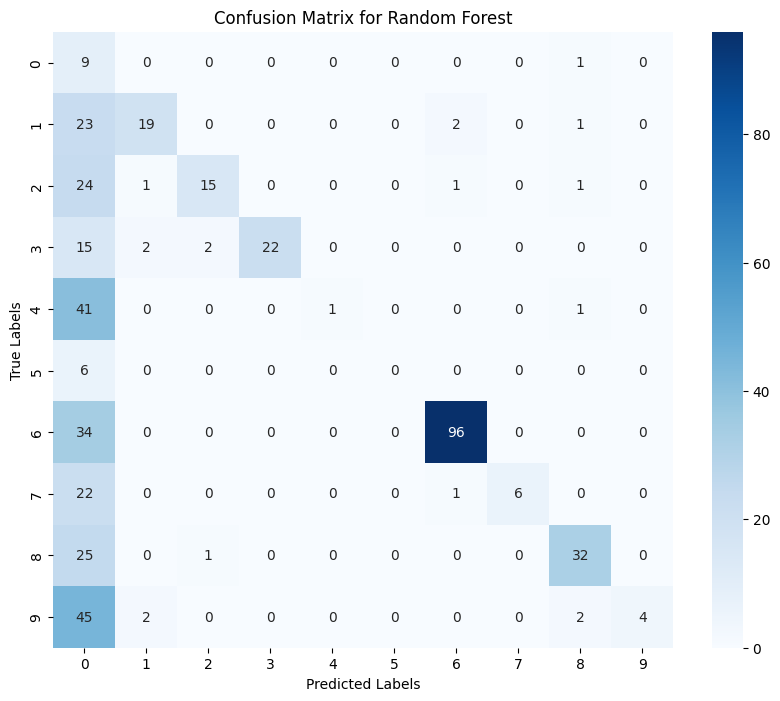

In [ ]:
# Assuming y_test and y_pred_rf are defined from your Random Forest model
cm_rf = confusion_matrix(y_test.argmax(axis=1), y_pred_rf.argmax(axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

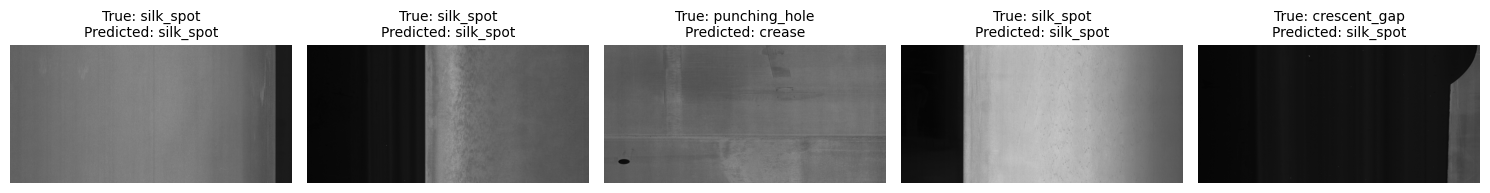

In [ ]:
# Get a sample of 5 indices from the test set
sample_indices = random.sample(range(len(test_df)), 5)

# Get the corresponding filepaths and true labels from the test set
sample_filepaths = test_df.iloc[sample_indices]['image_path'].values
sample_true_labels = test_df.iloc[sample_indices]['mapped_label'].values

# Create a dictionary mapping class indices to class labels
class_labels = validation_generator.class_indices
inverse_class_labels = {v: k for k, v in class_labels.items()}

# Get the predicted labels for the samples
sample_predicted_labels = [inverse_class_labels[label] for label in y_pred_rf.argmax(axis=1)[sample_indices]]


# Plot the images with correct and predicted labels
plt.figure(figsize=(15, 10))

for i, index in enumerate(sample_indices):
    img = cv2.imread(sample_filepaths[i])
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {sample_true_labels[i]}\nPredicted: {sample_predicted_labels[i]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
cnn_model.save('cnn_model.h5')
cnn_model = tf.keras.models.load_model('cnn_model.h5')

In [ ]:
import joblib
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

### VGG

In [13]:

# Load the pre-trained VGG16 model (without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for defect detection
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_df['mapped_label'].unique()), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [14]:
model.load_weights("vgg_defect_classification.weights.h5")
print("Model weights loaded successfully.")

Model weights loaded successfully.


In [ ]:
# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 44s 683ms/step - accuracy: 0.2700 - loss: 2.2136 - val_accuracy: 0.4661 - val_loss: 1.7535
Epoch 2/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 580ms/step - accuracy: 0.4055 - loss: 1.7447 - val_accuracy: 0.4639 - val_loss: 1.5649
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 565ms/step - accuracy: 0.4691 - loss: 1.6035 - val_accuracy: 0.4945 - val_loss: 1.4545
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 625ms/step - accuracy: 0.4997 - loss: 1.4728 - val_accuracy: 0.5864 - val_loss: 1.3879
Epoch 5/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 638ms/step - accuracy: 0.5349 - loss: 1.3769 - val_accuracy: 0.5186 - val_loss: 1.3696
Epoch 6/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 624ms/step - accuracy: 0.5335 - loss: 1.3628 - val_accuracy: 0.5602 - val_loss: 1.2796
Epoch 7/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 566ms/step - accuracy: 0.5779 - loss: 1.2446 - val_accuracy: 0.5689 - val_loss: 1.2581
Epoch 8/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 555ms/step - accuracy: 0.5631 - loss: 1.3143 - 

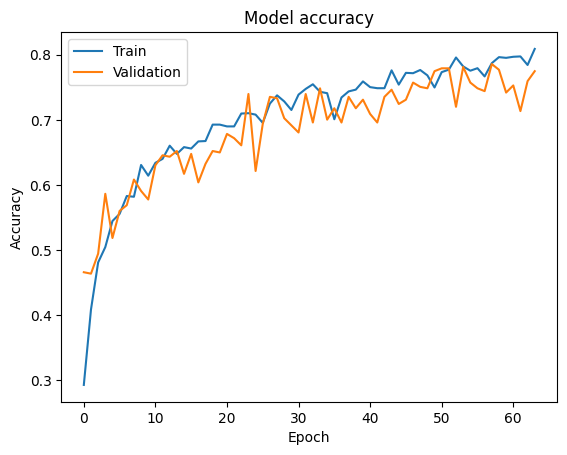

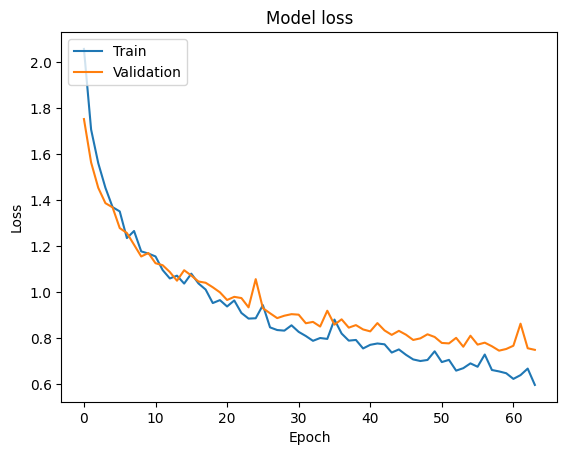

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(validation_generator)
print('Test accuracy:', accuracy)

15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 945ms/step - accuracy: 0.8256 - loss: 0.6116
Test accuracy: 0.822510838508606


In [24]:
# Calculate accuracy score for training set

# Predict on the training data
train_predictions = model.predict(train_generator)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

# Calculate the accuracy score
vgg_train_accuracy = accuracy_score(train_true_labels, train_predicted_labels)
print("Training Accuracy:", vgg_train_accuracy)

58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 474ms/step
Training Accuracy: 0.8530368763557483


In [17]:
# Get predictions for the validation data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
Y_true = validation_generator.classes

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 517ms/step


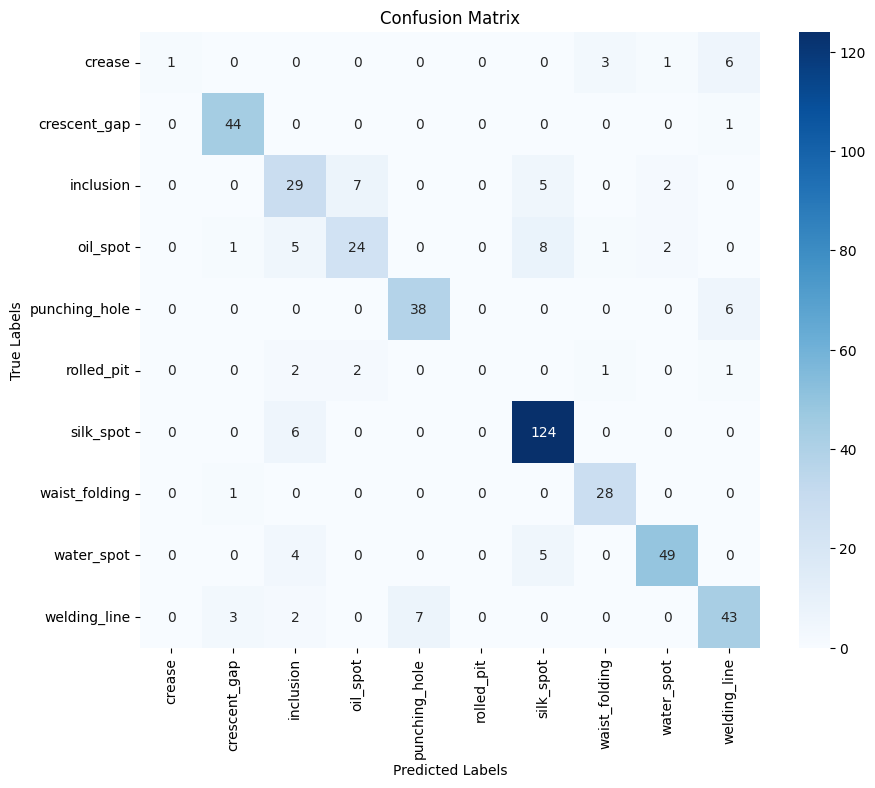

In [18]:
# plot the confusion matrix of model
# Compute the confusion matrix
cm = confusion_matrix(Y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
#print classification report

print(classification_report(Y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))

               precision    recall  f1-score   support

       crease       1.00      0.09      0.17        11
 crescent_gap       0.90      0.98      0.94        45
    inclusion       0.60      0.67      0.64        43
     oil_spot       0.73      0.59      0.65        41
punching_hole       0.84      0.86      0.85        44
   rolled_pit       0.00      0.00      0.00         6
    silk_spot       0.87      0.95      0.91       130
waist_folding       0.85      0.97      0.90        29
   water_spot       0.91      0.84      0.88        58
 welding_line       0.75      0.78      0.77        55

     accuracy                           0.82       462
    macro avg       0.75      0.67      0.67       462
 weighted avg       0.82      0.82      0.81       462



In [23]:
# print accuracy score, precision score, recall score
# Y_true and y_pred are already defined from previous code
vgg_test_accuracy = accuracy_score(Y_true, y_pred)
vgg_precision = precision_score(Y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
vgg_recall = recall_score(Y_true, y_pred, average='weighted')      # Use 'weighted' for multi-class

print(f"Accuracy: {vgg_test_accuracy}")
print(f"Precision: {vgg_precision}")
print(f"Recall: {vgg_recall}")

Accuracy: 0.8225108225108225
Precision: 0.8151712389007343
Recall: 0.8225108225108225


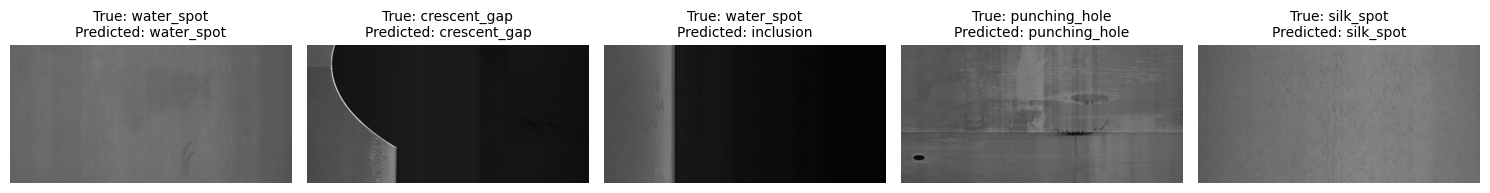

In [22]:
# Plot the images with Correct and Predicted Labels for 5 samples from test set
# Get a sample of 5 indices from the test set
sample_indices = random.sample(range(len(test_df)), 5)

# Get the corresponding filepaths and true labels from the test set
sample_filepaths = test_df.iloc[sample_indices]['image_path'].values
sample_true_labels = test_df.iloc[sample_indices]['mapped_label'].values


# Create a dictionary mapping class indices to class labels
class_labels = validation_generator.class_indices
inverse_class_labels = {v: k for k, v in class_labels.items()}

# Get the predicted labels for the samples
sample_predicted_labels = [inverse_class_labels[label] for label in y_pred[sample_indices]]

# Plot the images with correct and predicted labels
plt.figure(figsize=(15, 10))

for i, index in enumerate(sample_indices):
  img = cv2.imread(sample_filepaths[i])
  plt.subplot(1, 5, i + 1)
  plt.imshow(img)
  plt.title(f"True: {sample_true_labels[i]}\nPredicted: {sample_predicted_labels[i]}", fontsize=10)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# model.save_weights("vgg_defect_classification.weights.h5")
# print("Model weights saved successfully.")

Model weights saved successfully.


### Resnet + Attention Mechanism

In [25]:
#Build a model for Resnet with Attention Mechanism

def attention_block(input_tensor, ratio=8):
    channel_axis = -1
    num_channels = int(input_tensor.shape[channel_axis])

    shared_layer_one = Dense(num_channels // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(num_channels,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = Reshape((1, 1, num_channels))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalAveragePooling2D()(input_tensor)
    max_pool = Reshape((1, 1, num_channels))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_tensor, cbam_feature])

In [26]:
# Load the pre-trained ResNet50 model (without the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add attention block
x = base_model.output
x = attention_block(x) # Apply attention
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(train_df['mapped_label'].unique()), activation='softmax')(x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [27]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.load_weights("resnet_classification.weights.h5")
print("Model weights loaded successfully.")


Model weights loaded successfully.


In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5875 - loss: 1.2818 - val_accuracy: 0.0919 - val_loss: 129.9221
Epoch 2/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 617ms/step - accuracy: 0.7232 - loss: 0.8938 - val_accuracy: 0.0897 - val_loss: 15.1651
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 645ms/step - accuracy: 0.7793 - loss: 0.6906 - val_accuracy: 0.1160 - val_loss: 2.4531
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 621ms/step - accuracy: 0.8054 - loss: 0.5489 - val_accuracy: 0.2845 - val_loss: 2.9486
Epoch 5/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 45s 682ms/step - accuracy: 0.8200 - loss: 0.5107 - val_accuracy: 0.2845 - val_loss: 2.4070
Epoch 6/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 655ms/step - accuracy: 0.8284 - loss: 0.5086 - val_accuracy: 0.1269 - val_loss: 8.3090
Epoch 7/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 43s 701ms/step - accuracy: 0.8457 - loss: 0.4608 - val_accuracy: 0.0656 - val_loss: 2.8282
Epoch 8/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 635ms/step - accuracy: 0.8793 - loss: 0.3024 - 

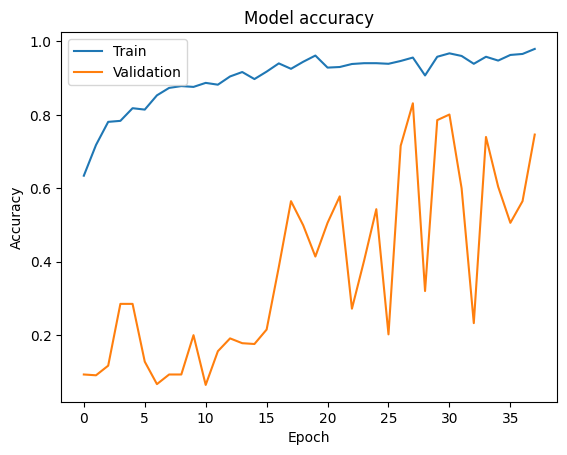

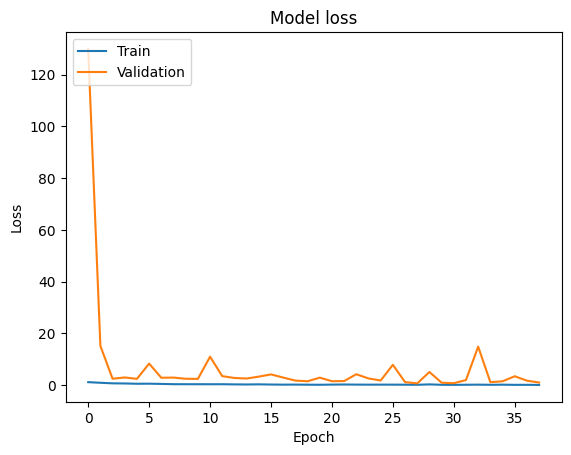

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
# Calculate accuracy score for training set

# Predict on the training data
train_predictions = model.predict(train_generator)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

# Calculate the accuracy score
resnet_train_accuracy = accuracy_score(train_true_labels, train_predicted_labels)
print("Training Accuracy:", resnet_train_accuracy)

58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 565ms/step
Training Accuracy: 0.8552060737527115


In [30]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(validation_generator)
print('Test accuracy:', accuracy)

15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 736ms/step - accuracy: 0.8401 - loss: 0.4043
Test accuracy: 0.8419913649559021


In [31]:
# Get predictions for the validation data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
Y_true = validation_generator.classes

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 479ms/step


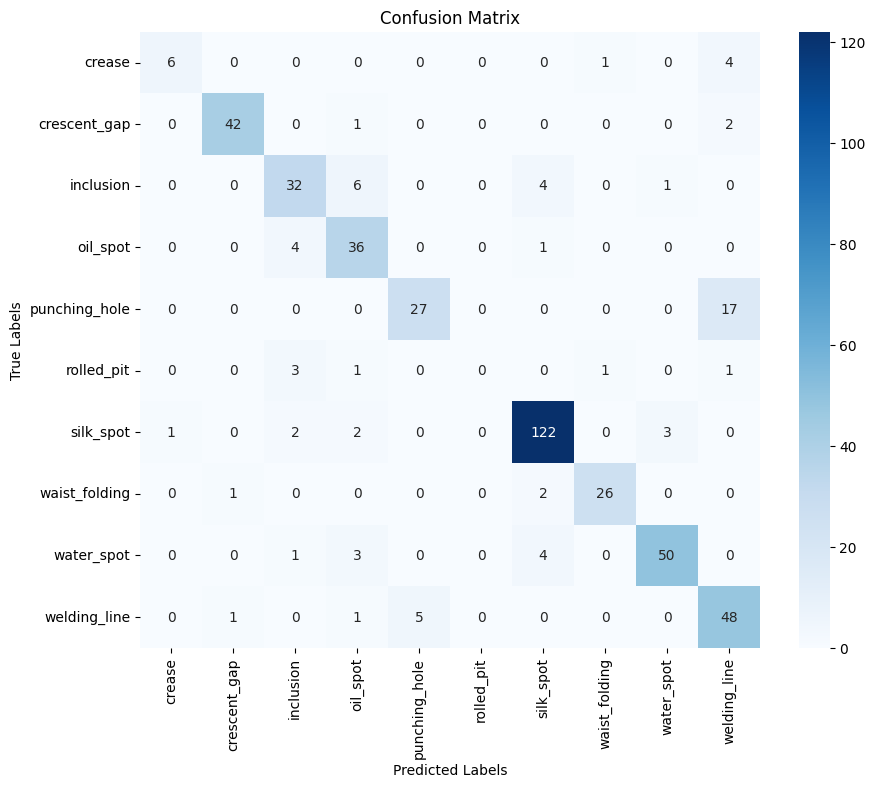

In [32]:
# Compute the confusion matrix
cm = confusion_matrix(Y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:
#print classification report

print(classification_report(Y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))

               precision    recall  f1-score   support

       crease       0.86      0.55      0.67        11
 crescent_gap       0.95      0.93      0.94        45
    inclusion       0.76      0.74      0.75        43
     oil_spot       0.72      0.88      0.79        41
punching_hole       0.84      0.61      0.71        44
   rolled_pit       0.00      0.00      0.00         6
    silk_spot       0.92      0.94      0.93       130
waist_folding       0.93      0.90      0.91        29
   water_spot       0.93      0.86      0.89        58
 welding_line       0.67      0.87      0.76        55

     accuracy                           0.84       462
    macro avg       0.76      0.73      0.74       462
 weighted avg       0.84      0.84      0.84       462



In [34]:
# print accuracy score, precision score, recall score
resnet_accuracy = accuracy_score(Y_true, y_pred)
resnet_precision = precision_score(Y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
resnet_recall = recall_score(Y_true, y_pred, average='weighted')      # Use 'weighted' for multi-class

print(f"Accuracy: {resnet_accuracy}")
print(f"Precision: {resnet_precision}")
print(f"Recall: {resnet_recall}")

Accuracy: 0.841991341991342
Precision: 0.8405564583218946
Recall: 0.841991341991342


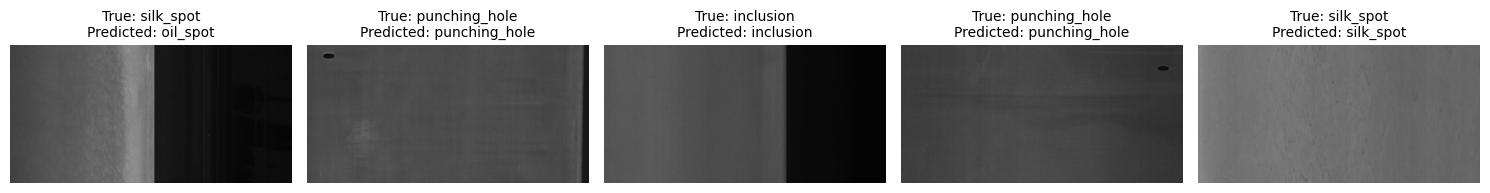

In [35]:
# Get a sample of 5 indices from the test set
sample_indices = random.sample(range(len(test_df)), 5)

# Get the corresponding filepaths and true labels from the test set
sample_filepaths = test_df.iloc[sample_indices]['image_path'].values
sample_true_labels = test_df.iloc[sample_indices]['mapped_label'].values


# Create a dictionary mapping class indices to class labels
class_labels = validation_generator.class_indices
inverse_class_labels = {v: k for k, v in class_labels.items()}

# Get the predicted labels for the samples
sample_predicted_labels = [inverse_class_labels[label] for label in y_pred[sample_indices]]

# Plot the images with correct and predicted labels
plt.figure(figsize=(15, 10))

for i, index in enumerate(sample_indices):
  img = cv2.imread(sample_filepaths[i])
  plt.subplot(1, 5, i + 1)
  plt.imshow(img)
  plt.title(f"True: {sample_true_labels[i]}\nPredicted: {sample_predicted_labels[i]}", fontsize=10)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Save the model weights in the file
model.save_weights("resnet_classification.weights.h5")
print("Model weights saved successfully.")

Model weights saved successfully.


### Few Shot Classification

In [31]:
#creating a training data for few shot classification model from above dataset
def create_few_shot_dataset(df, num_samples_per_class=10):
    few_shot_data = []
    classes = df['mapped_label'].unique()
    for cls in classes:
        class_data = df[df['mapped_label'] == cls]
        samples = random.sample(list(class_data.index), num_samples_per_class)
        few_shot_data.extend(samples)

    return df.loc[few_shot_data]

# Example usage
few_shot_train_df = create_few_shot_dataset(train_df, num_samples_per_class=15)
print(f"Size of Few shot Training Dataset: {len(few_shot_train_df)}")

few_shot_test_df = create_few_shot_dataset(test_df, num_samples_per_class=3) #smaller test set for few shot
print(f"Size of Few shot Test Dataset: {len(few_shot_test_df)}")

img_width, img_height = 224, 224

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

few_shot_train_generator = train_datagen.flow_from_dataframe(
    dataframe=few_shot_train_df,
    x_col='image_path',
    y_col='mapped_label',
    target_size=(img_width, img_height),
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',
    shuffle=False
)

few_shot_test_generator = test_datagen.flow_from_dataframe(
    dataframe=few_shot_test_df,
    x_col='image_path',
    y_col='mapped_label',
    target_size=(img_width, img_height),
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',
    shuffle=False
)

Size of Few shot Training Dataset: 150
Size of Few shot Test Dataset: 30
Found 150 validated image filenames belonging to 10 classes.
Found 30 validated image filenames belonging to 10 classes.


In [32]:
#few shot classification model

# Load the pre-trained VGG16 model (without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for defect detection
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(few_shot_train_df['mapped_label'].unique()), activation='softmax')(x)

# Create the final model
few_shot_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
few_shot_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [33]:
few_shot_model.load_weights("fewshot_classification.weights.h5")
print("Model weights loaded successfully.")

Model weights loaded successfully.


In [ ]:
# Train the model with early stopping
history = few_shot_model.fit(
    few_shot_train_generator,
    epochs=200,  # Or a smaller number for few-shot learning
    validation_data=few_shot_test_generator,
    callbacks=[early_stopping]
)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.1474 - loss: 2.5495 - val_accuracy: 0.2333 - val_loss: 2.2290
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.1925 - loss: 2.3517 - val_accuracy: 0.1333 - val_loss: 2.2154
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.1264 - loss: 2.2738 - val_accuracy: 0.3000 - val_loss: 2.1010
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - accuracy: 0.2287 - loss: 2.2416 - val_accuracy: 0.3000 - val_loss: 2.0386
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 0.2234 - loss: 2.1414 - val_accuracy: 0.3333 - val_loss: 1.9778
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.3636 - loss: 1.9693 - val_accuracy: 0.3333 - val_loss: 1.9345
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.3528 - loss: 1.8604 - val_accuracy: 0.4000 - val_loss: 1.9015
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - accuracy: 0.3588 - loss: 1.8786 - val_accuracy: 0.3667 - val

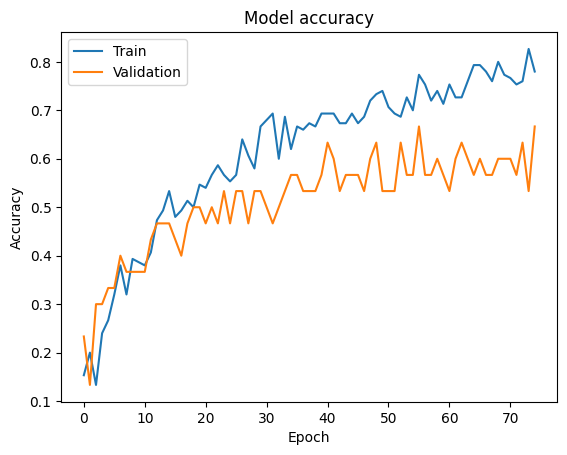

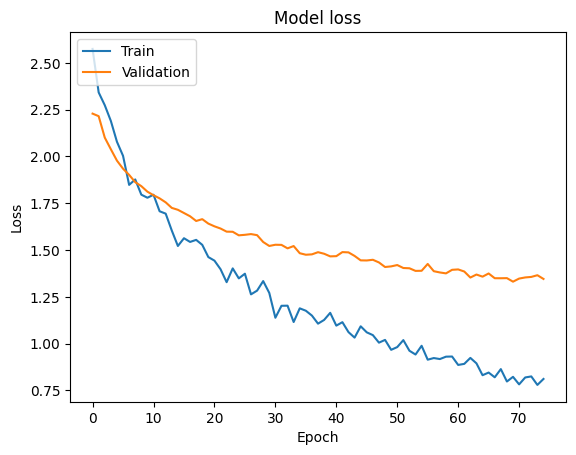

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
# Calculate accuracy score for training set

# Predict on the training data
train_predictions = few_shot_model.predict(few_shot_train_generator)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = few_shot_train_generator.classes

# Calculate the accuracy score
few_shot_train_accuracy = accuracy_score(train_true_labels, train_predicted_labels)
print("Training Accuracy:", few_shot_train_accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 681ms/step
Training Accuracy: 0.7933333333333333


In [38]:
loss, accuracy = few_shot_model.evaluate(few_shot_test_generator)
print('Few-shot Test accuracy:', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step - accuracy: 0.5667 - loss: 1.0935
Few-shot Test accuracy: 0.5666666626930237


In [36]:
# plot the confusion matrix of model
# Get predictions for the validation data
Y_pred = few_shot_model.predict(few_shot_test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
Y_true = few_shot_test_generator.classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


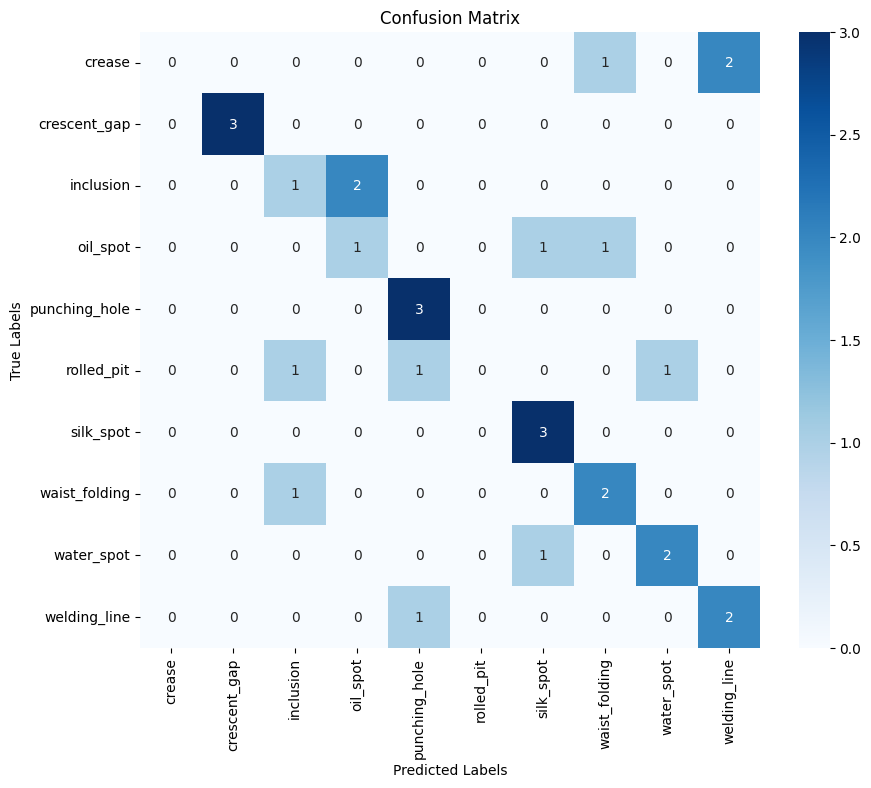

In [37]:
# Compute the confusion matrix
cm = confusion_matrix(Y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(few_shot_test_generator.class_indices.keys()),
            yticklabels=list(few_shot_test_generator.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
print(classification_report(Y_true, y_pred, target_names=list(few_shot_test_generator.class_indices.keys())))

               precision    recall  f1-score   support

       crease       0.00      0.00      0.00         3
 crescent_gap       1.00      1.00      1.00         3
    inclusion       0.33      0.33      0.33         3
     oil_spot       0.33      0.33      0.33         3
punching_hole       0.60      1.00      0.75         3
   rolled_pit       0.00      0.00      0.00         3
    silk_spot       0.60      1.00      0.75         3
waist_folding       0.50      0.67      0.57         3
   water_spot       0.67      0.67      0.67         3
 welding_line       0.50      0.67      0.57         3

     accuracy                           0.57        30
    macro avg       0.45      0.57      0.50        30
 weighted avg       0.45      0.57      0.50        30



In [40]:
# print accuracy score, precision score, recall score
# Y_true and y_pred are already defined from previous code
few_shot_accuracy = accuracy_score(Y_true, y_pred)
few_shot_precision = precision_score(Y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
few_shot_recall = recall_score(Y_true, y_pred, average='weighted')      # Use 'weighted' for multi-class

print(f"Accuracy: {few_shot_accuracy}")
print(f"Precision: {few_shot_precision}")
print(f"Recall: {few_shot_recall}")

Accuracy: 0.5666666666666667
Precision: 0.4533333333333333
Recall: 0.5666666666666667


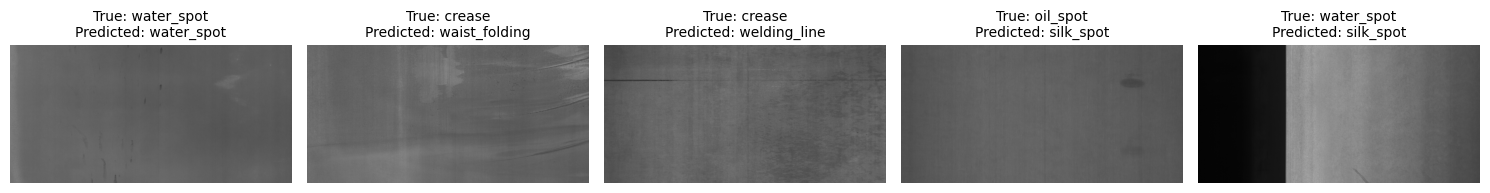

In [41]:
# Plot the images with Correct and Predicted Labels for 5 samples from test set

# Get a sample of 5 indices from the test set
sample_indices = random.sample(range(len(few_shot_test_df)), 5)

# Get the corresponding filepaths and true labels from the test set
sample_filepaths = few_shot_test_df.iloc[sample_indices]['image_path'].values
sample_true_labels = few_shot_test_df.iloc[sample_indices]['mapped_label'].values


# Create a dictionary mapping class indices to class labels
class_labels = validation_generator.class_indices
inverse_class_labels = {v: k for k, v in class_labels.items()}

# Get the predicted labels for the samples
sample_predicted_labels = [inverse_class_labels[label] for label in y_pred[sample_indices]]

# Plot the images with correct and predicted labels
plt.figure(figsize=(15, 10))

for i, index in enumerate(sample_indices):
  img = cv2.imread(sample_filepaths[i])
  plt.subplot(1, 5, i + 1)
  plt.imshow(img)
  plt.title(f"True: {sample_true_labels[i]}\nPredicted: {sample_predicted_labels[i]}", fontsize=10)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Save the model weights in the file
few_shot_model.save_weights("fewshot_classification.weights.h5")
print("Model weights saved successfully.")

Model weights saved successfully.
